<a href="https://colab.research.google.com/github/SverrirJan/Testing/blob/main/FiberOptics_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reynt að nota Machine learning fyrir Anomaly detection

Sækja gögn úr google-drive

In [ ]:
import numpy as np # Import numpy for loading .npz files
from google.colab import drive

drive.mount('/content/drive')

# Just to see if the files are there
#import os
# Change directory to the parent folder of the file
#os.chdir('/content/drive/MyDrive/FARICE/TimeDomain/Earthquake/')
# List the files in the current directory
#print(os.listdir())

file_path = '/content/drive/MyDrive/FARICE/TimeDomain/Earthquake/TimeDomain_File_2024-10-06-12_00_00_Offset_5_Dur_3_v1.npz'
#file_path = '/content/drive/MyDrive/FARICE/TimeDomain/Ocean/TimeDomain_File_2024-10-04-12_00_00_Offset_0_Dur_12_v1.npz'
# Use np.load to load .npz files
data = np.load(file_path)

fs= data['Fs']
tstart_hour = data['tstart_hour']
dur = data['dur']

# Print the loaded data
print(data.files) # Prints the arrays contained in the file
print(data['Fs'])
print(data['tstart_hour'])
print(data['dur'])
print(data['filename'])


Mounted at /content/drive
['Fs', 'sig', 'tstart_hour', 'dur', 'filename']
40
5
3
IRIS_Start_2024-10-06-12:00:00_Stop_2024-10-07-00:00:00


(431999,)


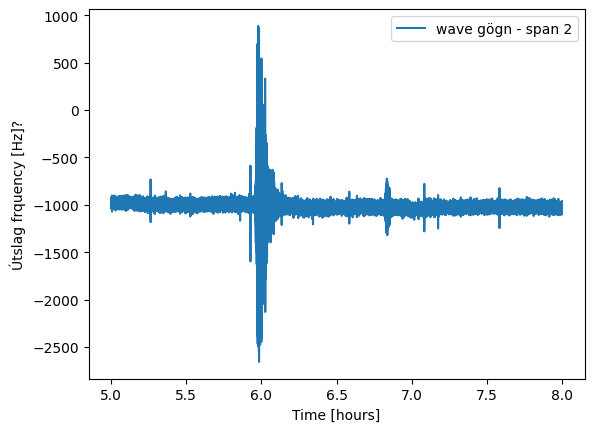

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create a NumPy matrix
signal_np_matrix = data['sig']

span_nr = 2
work_span = signal_np_matrix[span_nr-1, :]

print(np.shape(work_span))

## np.arange(start, stop, step):
td = np.arange(0, 1/(60*60*fs) * work_span.size, 1/(60*60*fs))

#plt.figure(figsize=(12,3))
plt.figure
plt.plot(td+tstart_hour, work_span,label='wave gögn - span ' + str(span_nr))
plt.xlabel('Time [hours]')
plt.ylabel('Útslag frquency [Hz]?')
plt.legend()

Skoðum spectrogram af gögnunum

Array Sxx.shape: (5121, 860)
Array frequencies.shape: (5121,)
Array times.shape: (860,)
max times 2696.7125
min times 1.6
max frequencies 80.0
min frequencies 0.0
max times_scaled 7.998220054974343
min times_scaled 5.0


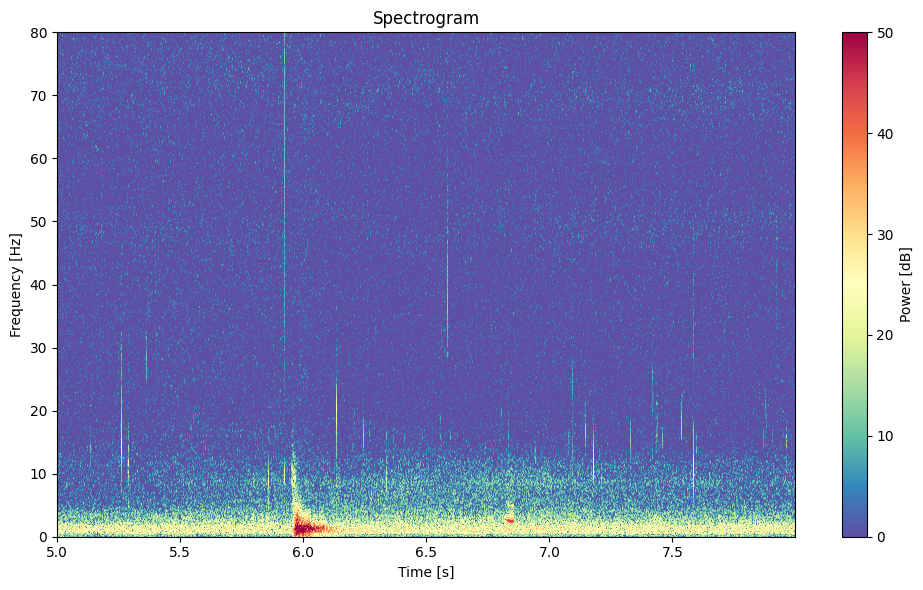

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from matplotlib.ticker import LogLocator

# Compute the spectrogram
frequencies, times, Sxx = spectrogram(work_span, fs*4, nfft=1024*10, nperseg=256*2, noverlap=10)

# frequencies, times, Sxx = spectrogram(
#    x,            # Input signal (1D array)
#    fs=1.0,       # Sampling frequency of the input signal
#    window='hann',# Desired window function (default: 'hann') e.g., 'hann', 'hamming', etc.
#    nperseg=256,  # Length of each segment (default: 256) for FFT
#    noverlap=None,# Number of points to overlap between segments (default: None)
#    nfft=None,    # Number of FFT points (default: None)
#    detrend='constant', # How to detrend each segment (default: 'constant')
#    return_onesided=True, # Return a one-sided spectrogram (default: True)
#    scaling='density',    # Scaling of the spectrum ('density' or 'spectrum')
#    axis=-1        # Axis along which to compute the spectrogram
#)

# Filter frequencies to range from 10^-3 to 10^2
min_freq, max_freq = 1e-3, 1e2
freq_mask = (frequencies >= min_freq) & (frequencies <= max_freq)
filtered_frequencies = frequencies[freq_mask]
filtered_Sxx = Sxx[freq_mask, :]  # Select rows corresponding to the filtered frequencies

#-------------------------------

print("Array Sxx.shape:", Sxx.shape)
print("Array frequencies.shape:", frequencies.shape)
print("Array times.shape:", times.shape)

print("max times", np.max(times))
print("min times", np.min(times))
print("max frequencies", np.max(frequencies))
print("min frequencies", np.min(frequencies))

times_scaled = (times-np.min(times))/(np.max(times)) * dur + tstart_hour
print("max times_scaled", np.max(times_scaled))
print("min times_scaled", np.min(times_scaled))

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times_scaled, frequencies, 10 * np.log10(Sxx), shading='auto', cmap='Spectral_r', vmin=0, vmax=50)
plt.title("Spectrogram")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
#plt.yscale('log')
plt.colorbar(label="Power [dB]")
plt.tight_layout()
#ax = plt.gca()
#ax.yaxis.set_major_locator(LogLocator(base=10.0))
#plt.ylim(min_freq, max_freq)  # Set the y-axis range explicitly
plt.show()


Nokkrar mjög einfaldar æfingar til að "grípa" hærri power tilvikin eftir fft


sum_Sxx.shape: (860,)
max sum_Sxx: 52334608.98103165
min sum_Sxx: 13220.626154197322
cut_line: 500000
filtered_arr.shape: (860,)


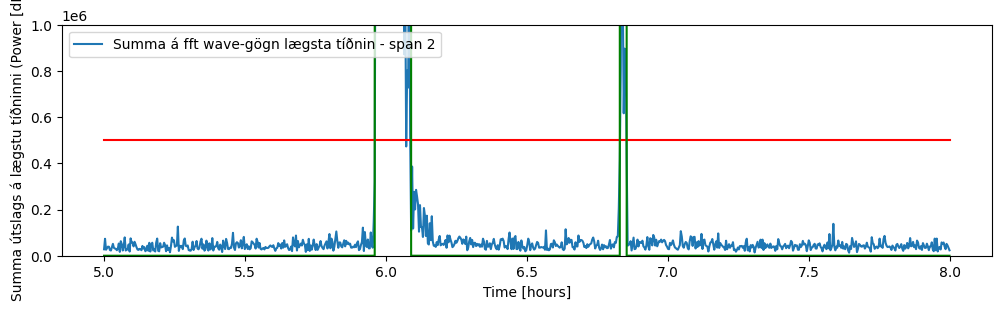

In [ ]:
# function to remove a single "true" or "false"
def remove_isolated_trues(arr):
    arr = arr.copy()  # Create a copy to avoid modifying the original
    for i in range(1, len(arr) - 1):  # Skip first and last element
        if arr[i] and not arr[i-1] and not arr[i+1]:  # Check if isolated
            arr[i] = False  # Change isolated True to False
        if not arr[i] and arr[i - 1] and arr[i + 1]:  # Check if isolated False
            arr[i] = True  # Change isolated False to True
    return arr

#############
band_min = 0
band_max = 5121
#Sxx_scaled = abs(10 * np.log10(Sxx[band_min:band_max, :]))
Sxx_scaled = abs(10 * np.log10(Sxx))
#sum_Sxx = np.sum(Sxx_scaled, axis=0)
sum_Sxx = np.sum(Sxx, axis=0)

print("sum_Sxx.shape:", sum_Sxx.shape)
print("max sum_Sxx:", max(sum_Sxx))
print("min sum_Sxx:", min(sum_Sxx))
#print("sum_Sxx:", sum_Sxx)

# eftir að finna betri dynamíska leið til að cutta
#cut_line = (band_max-band_min) * 5.5 + 5000
cut_line = 500000
line_x = [min(times_scaled),max(times_scaled)]
line_y = [cut_line, cut_line]

#grab the anomalty
over_line = sum_Sxx > cut_line

# removesingle "True" in array
filtered_arr = remove_isolated_trues(over_line)
filtered_arr1 = filtered_arr

#print("over_line.shape:", over_line.shape)
#print("over_line:", over_line)
#print("Modified:", filtered_arr)

print("cut_line:", cut_line)
print("filtered_arr.shape:", filtered_arr.shape)


plt.figure(figsize=(12,3))
plt.plot(times_scaled, sum_Sxx,label='Summa á fft wave-gögn lægsta tíðnin - span ' + str(span_nr))
plt.plot(line_x, line_y,color="red")
plt.plot(times_scaled, filtered_arr*max(sum_Sxx),color="green")
plt.xlabel('Time [hours]')
plt.ylabel('Summa útslags á lægstu tíðninni (Power [dB])')
plt.ylim(0, 500000*2)
plt.legend()


Unsupervised Methods (No Labels Available)
Used when you don't have labeled anomalies. These methods detect outliers based on patterns in the data.

🔹 Isolation Forest (IF)
Based on randomly partitioning data using decision trees.
Anomalies are isolated quickly since they require fewer splits.
Best for: High-dimensional tabular data.

X.shape: (5121, 860)
df.shape: (5121, 861)
df_normal.shape: (4865, 861)
df_anomaly.shape: (256, 861)
y_pred.shape: (5121,)
y_pred: [ 1 -1 -1 ...  1  1  1]
over_line_002.shape: (861,)
cut_line: 2000
filtered_arr.shape: (861,)


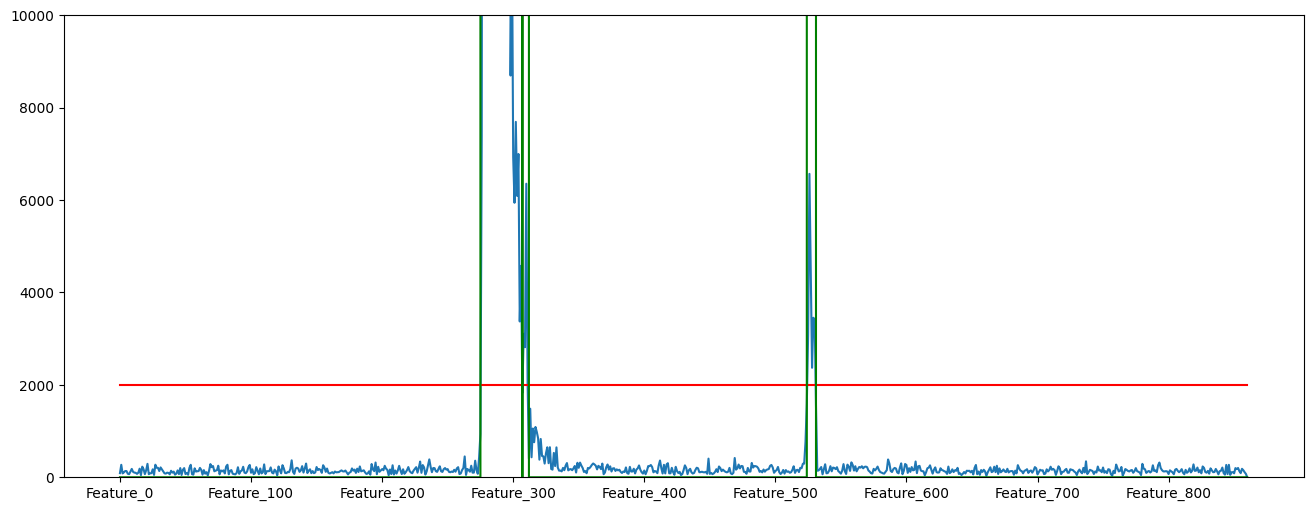

'\n# Scatter plot overlaying anomalies on original data\nplt.figure(figsize=(12, 6))\n#plt.pcolormesh(times_scaled, frequencies, X, shading=\'auto\', cmap=\'Spectral_r\', vmin=0, vmax=50)\nplt.pcolormesh(abs(10 * np.log10(df_anomaly)), shading=\'flat\', cmap=\'Spectral_r\', vmin=0, vmax=50)\n#sns.scatterplot(x=df_normal[feature_x], y=df_normal[feature_y], color="blue", label="Normal", alpha=0.6)\n#sns.scatterplot(x=df_anomaly[feature_x], y=df_anomaly[feature_y], color="red", label="Anomaly", marker="X", s=100)\nplt.xlabel(feature_x)\nplt.ylabel(feature_y)\nplt.title("Isolation Forest Anomaly Detection (Original Data)")\nplt.legend()\nplt.show()\n'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
#from sklearn.model_selection import train_test_split

#long_vector= abs(10 * np.log10(Sxx))
X = Sxx

"""
# No y (dependent variable)
X_train, X_test = train_test_split(long_vector, test_size=0.2, random_state=42)

# Step 3: Standardize the data (important for clustering)
#scaler = StandardScaler()
#subsections_scaled = scaler.fit_transform(X_train) #(subsections)

# Train Isolation Forest on X_train
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(X_train)

# Predict anomalies on test set
y_test_pred = model.predict(X_test)  # -1 = anomaly, 1 = normal
"""

# Train Isolation Forest on the entire dataset
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(X)

# Predict anomalies on the entire dataset X
y_pred = model.predict(X)  # -1 = anomaly, 1 = normal

# Convert results to DataFrame
df = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(X.shape[1])])
df["Anomaly Score"] = y_pred

# Select two features for visualization
feature_x, feature_y = "Feature_0", "Feature_1"

# Separate normal and anomaly samples
df_normal = df[df["Anomaly Score"] == 1]
df_anomaly = df[df["Anomaly Score"] == -1]

print("X.shape:", X.shape)
print("df.shape:", df.shape)
print("df_normal.shape:", df_normal.shape)
print("df_anomaly.shape:", df_anomaly.shape)
print("y_pred.shape:", y_pred.shape)
print("y_pred:", y_pred)

column_sums_normal = np.mean(df_normal, axis=0)
column_sums_anomaly = np.mean(df_anomaly, axis=0)

#print("column_sums_normal:", column_sums_normal)
#print("column_sums_anomaly:", column_sums_anomaly)

cut_line = 2000
line_x = [0,860]#[min(times_scaled),max(times_scaled)]
line_y = [cut_line, cut_line]

#grab the anomalty
over_line_002 = column_sums_anomaly > cut_line

print("over_line_002.shape:", over_line_002.shape)
#print("over_line_002:", over_line_002)
# removesingle "True" in array
#filtered_arr = remove_isolated_trues(over_line)
filtered_arr = over_line_002
#print("over_line.shape:", over_line.shape)
#print("over_line:", over_line)
#print("Modified:", filtered_arr)
filtered_arr2 = filtered_arr[0:860]

print("cut_line:", cut_line)
print("filtered_arr.shape:", filtered_arr.shape)

plt.figure(figsize=(16, 6))
#plt.plot(y_pred)
#plt.plot(column_sums_normal)
plt.plot(column_sums_anomaly)
plt.plot(line_x, line_y,color="red")
plt.plot(filtered_arr*max(sum_Sxx),color="green")
plt.xticks(np.arange(0, 860, 100))
plt.ylim(0, 10000)
plt.show()

"""
# Scatter plot overlaying anomalies on original data
plt.figure(figsize=(12, 6))
#plt.pcolormesh(times_scaled, frequencies, X, shading='auto', cmap='Spectral_r', vmin=0, vmax=50)
plt.pcolormesh(abs(10 * np.log10(df_anomaly)), shading='flat', cmap='Spectral_r', vmin=0, vmax=50)
#sns.scatterplot(x=df_normal[feature_x], y=df_normal[feature_y], color="blue", label="Normal", alpha=0.6)
#sns.scatterplot(x=df_anomaly[feature_x], y=df_anomaly[feature_y], color="red", label="Anomaly", marker="X", s=100)
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title("Isolation Forest Anomaly Detection (Original Data)")
plt.legend()
plt.show()
"""

Bera saman einfalda "æfingu" við Isolation Forest (IF) go skoða muninn (ef einhver)

In [ ]:
############
#over_line_diff = over_line_002.astype(int) - over_line.select_dtypes(include=np.number).astype(int) # Convert boolean to int and select only numerical types before subtraction.
print("sum filtered_arr:", filtered_arr.sum())
print("sum over_line_002:",over_line_002.sum())
print(type(over_line))
print(over_line.shape)
print(type(over_line_002))
print(over_line_002.shape)

bool_arr1 = filtered_arr.astype(bool)
bool_arr2 = over_line_002[0:860].astype(bool)
print("sum bool_arr1:", bool_arr1.sum())
print("sum bool_arr2:", bool_arr2.sum())

bool_diff = bool_arr1 ^ bool_arr2
print("sum bool_diff:", bool_diff.sum())
#print("sum over_line:", over_line.sum())

#print("count of over_line:", over_line)
#print("sum of over_line_002:", sum(over_line_002))
#print("sum of over_line:", over_line_diff.sum().sum()) # Use sum twice to calculate sum of all elements.


sum filtered_arr: 41
sum over_line_002: 41
<class 'numpy.ndarray'>
(860,)
<class 'pandas.core.series.Series'>
(861,)
sum bool_arr1: 41
sum bool_arr2: 41
sum bool_diff: 0


In [ ]:
"""
# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times_scaled, frequencies, X, shading='auto', cmap='Spectral_r', vmin=0, vmax=50)
sns.scatterplot(x=df_anomaly[feature_x], y=df_anomaly[feature_y], color="red", label="Anomaly", marker="X", s=100)
plt.title("Spectrogram")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
#plt.yscale('log')
plt.colorbar(label="Power [dB]")
plt.tight_layout()
#ax = plt.gca()
#ax.yaxis.set_major_locator(LogLocator(base=10.0))
#plt.ylim(min_freq, max_freq)  # Set the y-axis range explicitly
plt.show()
"""
######
"""
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the pcolormesh plot
#c = ax.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
c = ax.pcolormesh(times_scaled, frequencies, X, shading='auto', cmap='Spectral_r', vmin=0, vmax=50)

# Overlay scatter points on top
ax.scatter(scatter_x, scatter_y, c=scatter_values, cmap='coolwarm', edgecolors='black', s=100, label="Scatter Points")

# Add colorbars for pcolormesh and scatter points
fig.colorbar(c, ax=ax, label="pcolormesh colorbar")
scatter = ax.scatter(scatter_x, scatter_y, c=scatter_values, cmap='coolwarm', edgecolors='black', s=100)
fig.colorbar(scatter, ax=ax, label="Scatter colorbar")

# Set labels and title
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title("pcolormesh with Scatter Points Overlay")

# Show the plot
plt.legend()
plt.show()
"""
########
#print(df_anomaly)
"""
# Get the row and column indices for scatter_x and scatter_y
scatter_y, scatter_x = np.where(df_anomaly == -1)  # Adjust threshold to pick "anomalous" values

# Optionally, use the values in df_anomaly for color or size
scatter_values = df_anomaly[scatter_y, scatter_x]  # Use values for scatter color

# Create a plot with pcolormesh and scatter points
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the pcolormesh
X, Y = np.meshgrid(np.arange(df_anomaly.shape[1]), np.arange(df_anomaly.shape[0]))
c = ax.pcolormesh(X, Y, df_anomaly, shading='auto', cmap='viridis')

# Overlay the scatter points on the pcolormesh
ax.scatter(scatter_x, scatter_y, c=scatter_values, cmap='coolwarm', edgecolors='black', s=100, label="Anomalies")

# Add colorbars
fig.colorbar(c, ax=ax, label="pcolormesh colorbar")
scatter = ax.scatter(scatter_x, scatter_y, c=scatter_values, cmap='coolwarm', edgecolors='black', s=100)
fig.colorbar(scatter, ax=ax, label="Scatter colorbar")

# Set labels and title
ax.set_xlabel("Column Index")
ax.set_ylabel("Row Index")
ax.set_title("pcolormesh with Scatter Points Overlay")

# Show the plot
plt.legend()
plt.show()
"""

'\n# Get the row and column indices for scatter_x and scatter_y\nscatter_y, scatter_x = np.where(df_anomaly == -1)  # Adjust threshold to pick "anomalous" values\n\n# Optionally, use the values in df_anomaly for color or size\nscatter_values = df_anomaly[scatter_y, scatter_x]  # Use values for scatter color\n\n# Create a plot with pcolormesh and scatter points\nfig, ax = plt.subplots(figsize=(10, 8))\n\n# Plot the pcolormesh\nX, Y = np.meshgrid(np.arange(df_anomaly.shape[1]), np.arange(df_anomaly.shape[0]))\nc = ax.pcolormesh(X, Y, df_anomaly, shading=\'auto\', cmap=\'viridis\')\n\n# Overlay the scatter points on the pcolormesh\nax.scatter(scatter_x, scatter_y, c=scatter_values, cmap=\'coolwarm\', edgecolors=\'black\', s=100, label="Anomalies")\n\n# Add colorbars\nfig.colorbar(c, ax=ax, label="pcolormesh colorbar")\nscatter = ax.scatter(scatter_x, scatter_y, c=scatter_values, cmap=\'coolwarm\', edgecolors=\'black\', s=100)\nfig.colorbar(scatter, ax=ax, label="Scatter colorbar")\n\n# Se

🔹 One-Class SVM (Support Vector Machine)
Trains a model to separate normal data from anomalies using a hyperplane.
Works well for small datasets but struggles with large, high-dimensional data.

In [ ]:
#dir(model)

X.shape: (5121, 860)
anomalies.shape: (5121,)
anomalies: [ 1 -1 -1 ...  1  1 -1]
Count anomalies 256
Count normal 4865
result.shape: (860,)
anomalies_boolean.shape: (5121,)
over_line_003.shape (860,)


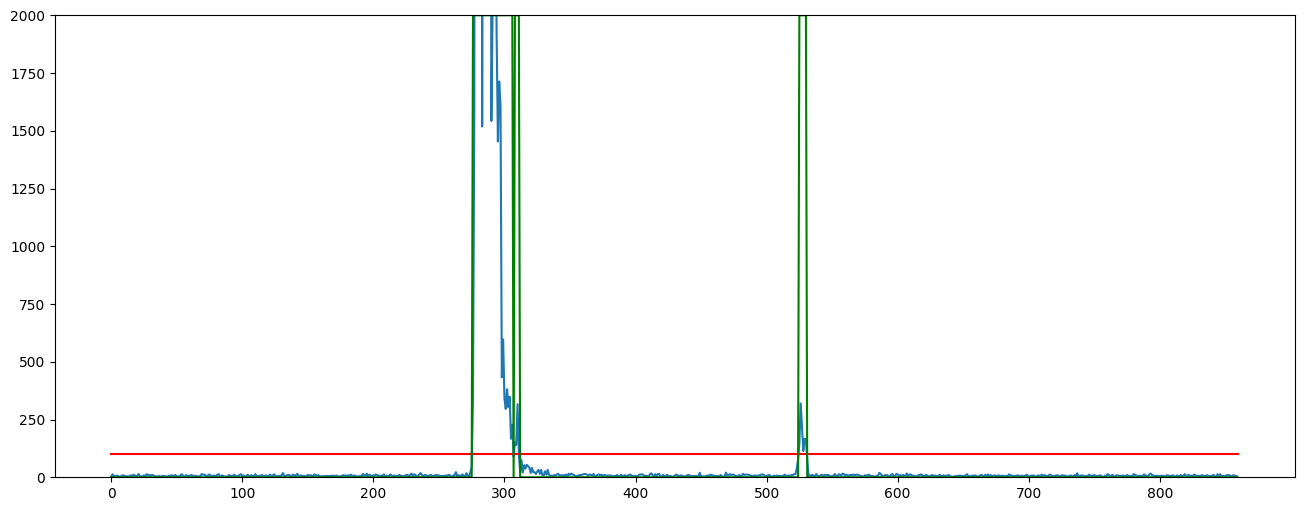

In [ ]:
from sklearn.svm import OneClassSVM

model = OneClassSVM(nu=0.05, kernel="rbf")  # nu = proportion of anomalies
model.fit(X)
anomalies = model.predict(X)  # -1 = anomaly, 1 = normal

print("X.shape:", X.shape)
print("anomalies.shape:", anomalies.shape)
print("anomalies:", anomalies)
print("Count anomalies", np.sum(anomalies == -1))
print("Count normal", np.sum(anomalies == 1))

#anom_diff = anomalies - y_pred
#anom_diff = over_line_003 ^ over_line_002[0:860]

#print("Count anom_diff", np.sum(anom_diff == -2))

anomalies_boolean = np.where(anomalies == 1, 0, 1)
result = np.mean(X * anomalies_boolean[:, np.newaxis], axis=0)

cut_line = 100
top_value = 2000
line_x = [0,860]#[min(times_scaled),max(times_scaled)]
line_y = [cut_line, cut_line]

#grab the anomalty
over_line_003 = result > cut_line
#filtered_arr = over_line_003
filtered_arr3 = over_line_003

print("result.shape:", result.shape)
print("anomalies_boolean.shape:", anomalies_boolean.shape)
print("over_line_003.shape", over_line_003.shape)

plt.figure(figsize=(16, 6))
plt.plot(result)
plt.plot(line_x, line_y,color="red")
plt.plot(over_line_003*top_value,color="green")
plt.xticks(np.arange(0, 860, 100))
plt.ylim(0, top_value)
plt.show()


<ipython-input-4-e8964a005081>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if arr[i] and not arr[i-1] and not arr[i+1]:  # Check if isolated
<ipython-input-4-e8964a005081>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not arr[i] and arr[i - 1] and arr[i + 1]:  # Check if isolated False
<ipython-input-4-e8964a005081>:8: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  arr[i] = True  # Change isolated False to True


Compare 1 and 2: 0
Compare 1 and 3: 0
Compare 2 and 3: 0


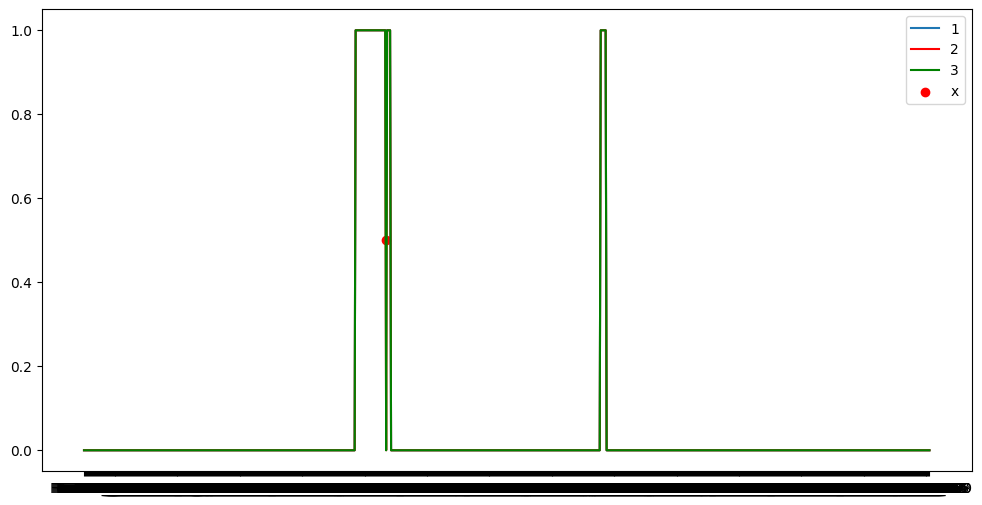

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [ ]:
#print("Compare 1 and 2:", filtered_arr1.astype(int)-filtered_arr2.astype(int))
#print("Compare 1 and 3:", filtered_arr1.astype(int)-filtered_arr3.astype(int))
#print("Compare 2 and 3:", filtered_arr2.astype(int)-filtered_arr3.astype(int))

comp_1_2 = filtered_arr1.astype(bool)[0:860] ^ remove_isolated_trues(filtered_arr2.astype(bool))
comp_1_3 = filtered_arr1.astype(bool) ^ remove_isolated_trues(filtered_arr3.astype(bool))
comp_2_3 = filtered_arr2.astype(bool) ^ filtered_arr3.astype(bool)[0:860]

print("Compare 1 and 2:", np.sum(comp_1_2))
print("Compare 1 and 3:", np.sum(comp_1_3))
print("Compare 2 and 3:", np.sum(comp_2_3))

plt.figure(figsize=(12, 6))
plt.plot(filtered_arr1.astype(bool), label='1')
plt.plot(filtered_arr2.astype(bool),color="red", label='2')
plt.plot(filtered_arr3.astype(bool),color="green", label='3')
#plt.xticks(np.arange(0, 860, 100))
#plt.ylim(0, top_value)

indices = np.where(comp_1_2 == True)
x = 307 #indices
y = 0.5

# Create a plot and plot the point
plt.scatter(x, y, color='red', label='x')

plt.legend()
plt.show()

indices = np.where(comp_1_2 == True)
print(indices)
indices = np.where(comp_1_3 == True)
print(indices)
indices = np.where(comp_2_3 == True)
print(indices)


Isolation forrest tekið á hinn kantinn (skoða allar tíðnirnar, en ekki tímann)

X.shape: (860, 5121)
df.shape: (860, 5122)
df_normal.shape: (817, 5122)
df_anomaly.shape: (43, 5122)
y_pred.shape: (860,)


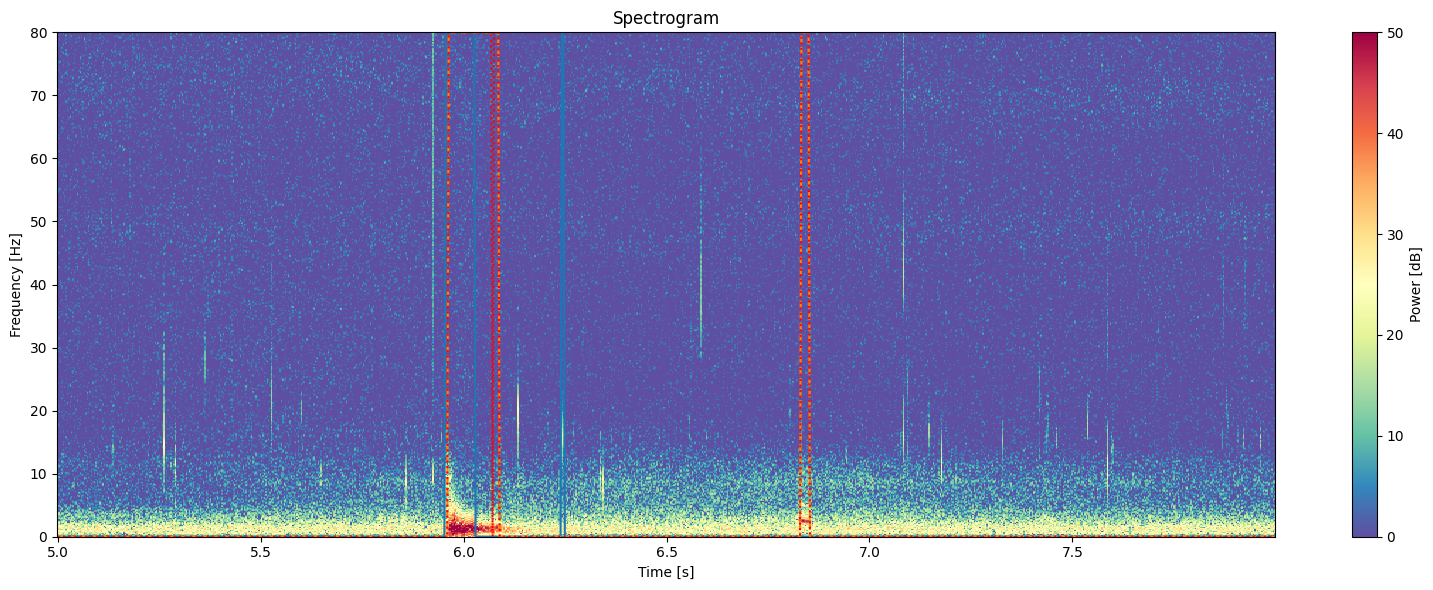

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest


#long_vector= abs(10 * np.log10(Sxx))
X = Sxx.T

# Train Isolation Forest on the entire dataset
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(X)

# Predict anomalies on the entire dataset X
y_pred = model.predict(X)  # -1 = anomaly, 1 = normal

# Convert results to DataFrame
df = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(X.shape[1])])
df["Anomaly Score"] = y_pred
# Separate normal and anomaly samples
df_normal = df[df["Anomaly Score"] == 1]
df_anomaly = df[df["Anomaly Score"] == -1]

print("X.shape:", X.shape)
print("df.shape:", df.shape)
print("df_normal.shape:", df_normal.shape)
print("df_anomaly.shape:", df_anomaly.shape)
print("y_pred.shape:", y_pred.shape)
#print("y_pred:", y_pred)

y_pred_filt = remove_isolated_trues((y_pred+1).astype(bool))
#y_pred_filt = (y_pred+1).astype(bool)

plt.figure(figsize=(16, 6))
#plt.plot(y_pred)
plt.plot(times_scaled,~y_pred_filt*80)

plt.plot(times_scaled,filtered_arr1.astype(bool)*80, linestyle='--', label='1')
#plt.plot(filtered_arr2.astype(bool),color="red", label='2')
plt.plot(times_scaled,filtered_arr3.astype(bool)*80,color="red", linestyle=':', label='3')

#plt.plot(column_sums_normal)
#plt.plot(column_sums_anomaly)
#plt.plot(line_x, line_y,color="red")
#plt.plot(filtered_arr*max(sum_Sxx),color="green")
#plt.xticks(np.arange(0, 860, 100))
#plt.ylim(0, 10000)


# Plot the spectrogram

plt.pcolormesh(times_scaled, frequencies, 10 * np.log10(Sxx), shading='auto', cmap='Spectral_r', vmin=0, vmax=50)
plt.title("Spectrogram")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
#plt.yscale('log')
plt.colorbar(label="Power [dB]")
plt.tight_layout()
#ax = plt.gca()
#ax.yaxis.set_major_locator(LogLocator(base=10.0))
#plt.ylim(min_freq, max_freq)  # Set the y-axis range explicitly
plt.show()
